# Стохастический анализ (2024)
# Домашнее Задание 1 (программная часть)

Дробышевский Илья

Оценка(итоговая за ДЗ): 100 из 100 + бонус(0)


Задачи: 50 из 50

Ноутбук: 50 из 50


Дедлайн:  2359МСК

Решённый ноутбук нужно засабмитить в класрум курса

Пожалуйста, называйте файл(ы) в формате <Имя>HW1.pdf или <Имя>HW1.ipynb. Например, KaledinHW1.pdf и KaledinHW1.ipynb.

In [1]:
#all imports here, please
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import scipy
import sklearn.linear_model

## Часть 1: Оценка параметров в модели Блэка-Шоулза (20 баллов)

В одной из первых классических финансовых моделей цены акций моделируются с помощью процесса геометрического Броуновского движения (GBM). Пусть $(W_t)_{t \in \mathbb{R}_+}$ -- Винеровский процесс, тогда процесс геометрического Броуновского движения задаётся как

$$
X_t = X_0 e^{(\mu-\sigma^2/2)t + \sigma W_t},
$$

$\mu$ -- параметр сноса (связан с безрисковой процентной ставкой),  $\sigma$ -- параметр волатильности (показывающий насколько интенсивно цена может колебаться, связан с активностью инвесторов). Ваша задача в этом упражнении построить первую модель для оценки параметров по имеющейся дискретной реализации процесса.

### Вывод формул для параметров

Пусть даны $X_0,X_{t_1}..,X_{t_n}$ -- часть траектории процесса, мы хотим подогнать параметры $\mu,\sigma$ в предположении, что наблюдения пришли из геометрического Броуновского движения. Обычная регрессия в данном случае нам не подойдёт, так как мы имеем дело с нелинейной моделью и наблюдения $X_i$ зависимы. Но можно выписать функцию правдоподобия, если вспомнить, что логарифмы
$\ln \frac{X_t}{X_{t-1}}$ 
независимы.

#### Функция правдоподобия

Пусть даны $t_0=0,t_1,..,t_n$ и $X_0,X_1,..,X_n$ (например, данные собранные на бирже). Выпишите функцию правдоподобия $L(\mu,\sigma)$ для модели, возьмите в конце логарифм, так как с ним будет удобнее работать.

ВАШЕ РЕШЕНИЕ В ЭТОМ ОКНЕ

#### Вычисление производных

Вычислите производные функции $\ln L(\mu,\sigma)$.

ВАШЕ РЕШЕНИЕ

$$
\partial_\mu \ln L = ???
$$

$$
\partial_\sigma \ln L = ???
$$

#### Запись формул для $\mu,\sigma$

Найдите $\mu,\sigma$, приравняв производные к нулю (в этих точках функция действительно будет иметь максимум, проверяется вычислением матрицы Гессе, но здесь это делать не нужно).

ВАШЕ РЕШЕНИЕ

$$
\mu = ???
$$

$$
\sigma = ???
$$

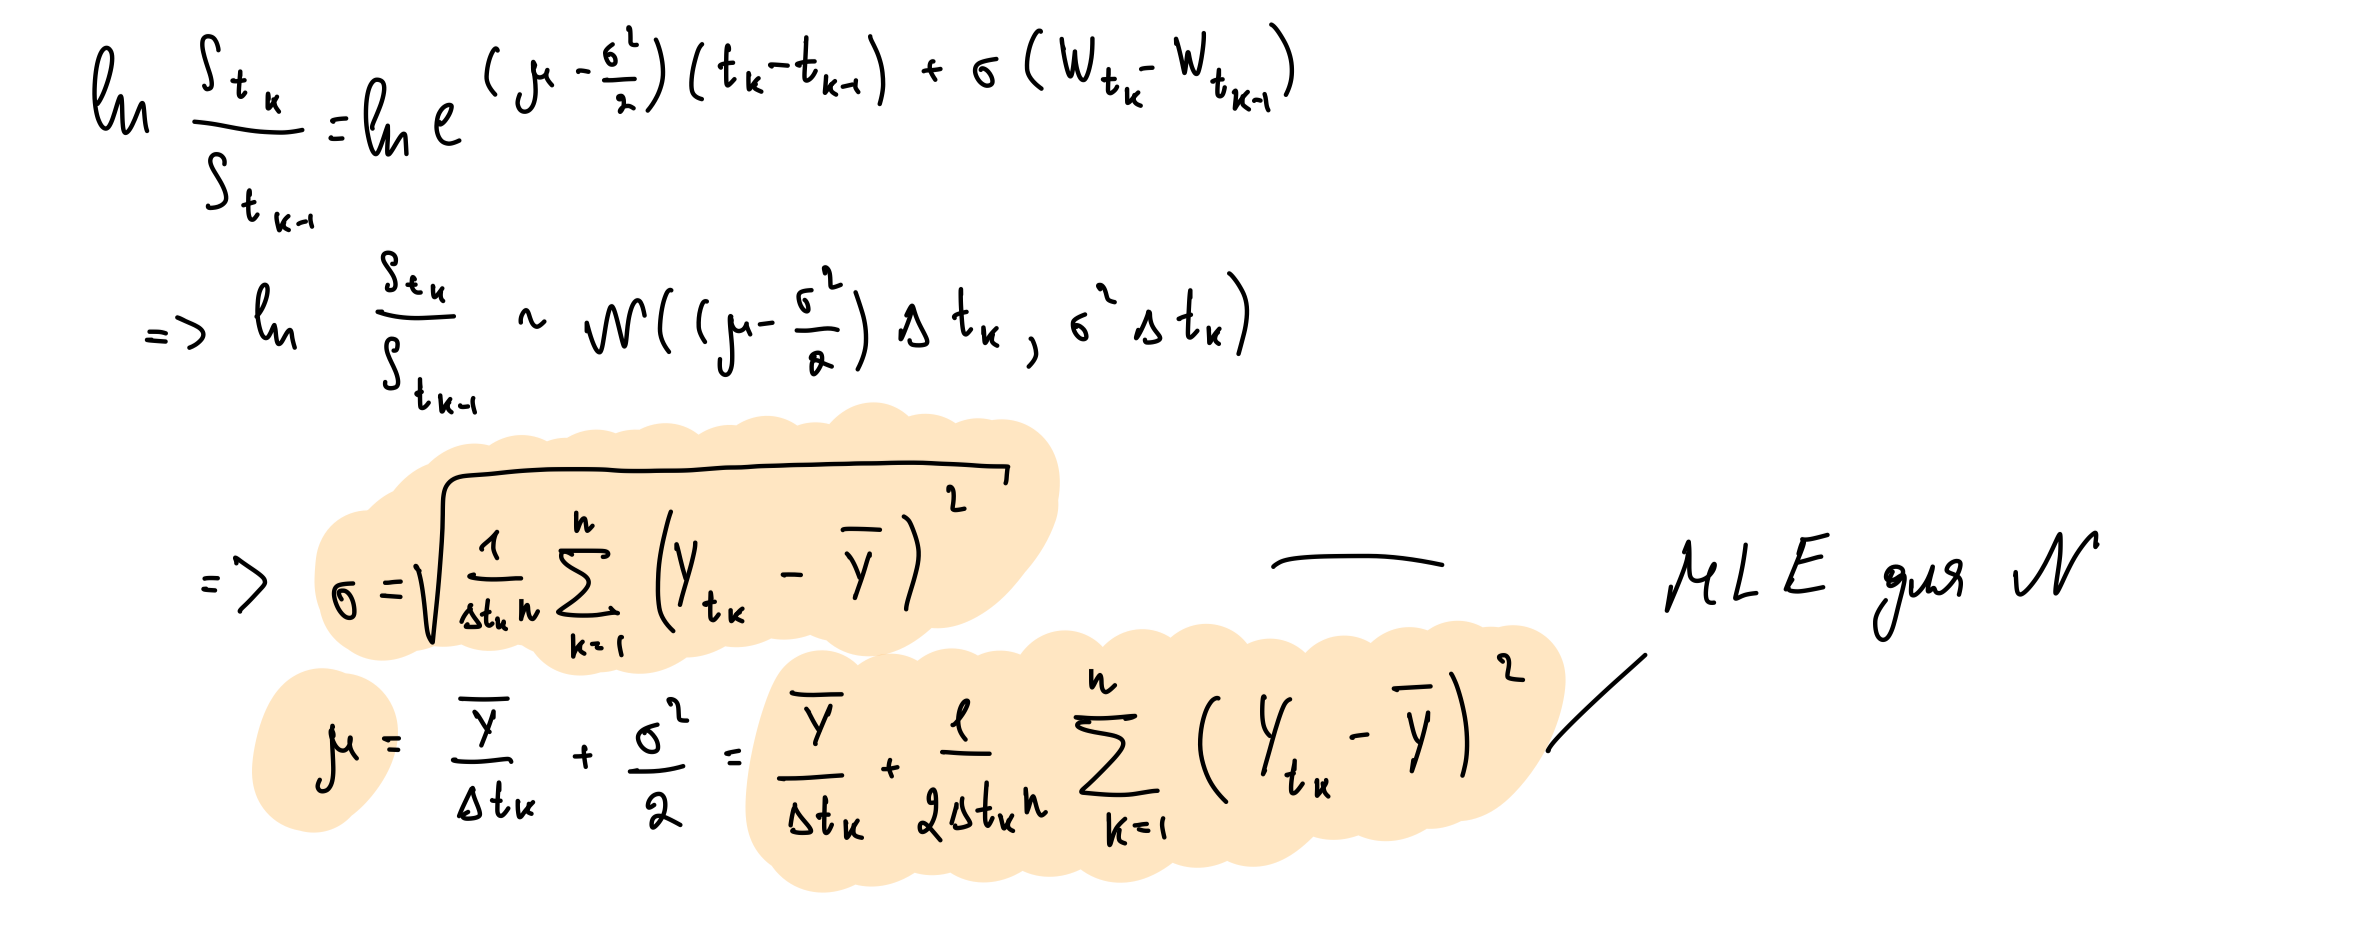

### Воплощение в коде

Теперь имплементируйте модель оценки, используйте для основы код ниже. Нам также понадобится код для симуляции Винеровского процесса.

In [2]:
def simulateWienerProcess(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float x0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,len(ts))
    '''
    np.random.seed(228)
    xs = np.zeros((Ntraj, len(ts)))
    xs[..., 0] = x0
    for t in range(1, len(ts)):
        xs[..., t] = xs[..., t - 1] + np.random.normal(0, np.sqrt(ts[t] - ts[t-1]), (Ntraj, ))
    return xs

class GBMModel:
    '''
        Implements Geometric Brownian Motion, allowing for parameter estimation and simulations
    '''

    def __init__(self, mu=0,sigma=1):
        '''
        Input
        float mu -- drift parameter (if pre-defined)
        float sigma -- volatility (if pre-defined)
        '''
        self.mu=mu
        self.sigma=sigma


    def fit(self, xs, ts):
        '''
        Fits the parameters to the given time series
        Input
        float[] xs -- observations
        float[] ts -- times (same shape as xs)
        '''
        #YOUR CODE
        y = np.log(xs)
        y = y[1:] - y[:-1]
        self.sigma = np.std(y) / np.sqrt(ts[1] - ts[0])
        self.mu = np.mean(y) / (ts[1] - ts[0]) + self.sigma ** 2 / 2
        

    def simulate(self,x0,ts,Ntraj,confLevel=0):
        '''
        Simulates trajectories of GBM with set mu and sigma
        Input
        float x0 -- initial price
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        float confLevel -- confidence level, set to non-zero if confInterval is needed
        Returns
        float[] of shape (Ntraj,len(ts)) , trajectories
        if confLevel!=0, 
        then returns  float[] (Ntraj,len(ts)), float[] (len(ts),), float[] (len(ts),) 
        which are trajectories, confidenceLow, confidenceHigh
        '''
        #YOUR CODE
        #Use simulateWienerProcess to simulateW trajectories of Wiener process
        #Based on that, compute GBM
        #For confidence intervals use the exponentiated gaussian intervals of (mu-sigma^2/2)t + sigma W_t
        xs = simulateWienerProcess(0, ts, Ntraj)
        ss = x0 * np.exp((self.mu - self.sigma ** 2 / 2) * ts + self.sigma * xs)
        if confLevel != 0:
            z = scipy.stats.norm.ppf(1 - (1 - confLevel / 100) / 2)
            confLow = ss.mean(axis=0) * np.exp(-0.5 * self.sigma ** 2 * ts - z * self.sigma * np.sqrt(ts))
            confHigh = ss.mean(axis=0) * np.exp(-0.5 * self.sigma ** 2 * ts + z * self.sigma * np.sqrt(ts))
            return ss, confLow, confHigh
        return ss

    def predict(self,x0,ts, confLevel=0):
        '''
        Makes a prediction based on the fact that at ts[0] the process value equals x0
        Input
        float x0 -- initial price
        float[] ts -- times for predictions
        Returns
        float[] preds, float[] confIntLows, float[] confIntHigh
        predictions (len(ts)), confIntLows (len(ts)), confIntHighs (len(ts))
        '''
        return self.simulate(x0, ts, 1, confLevel)

В качестве теста, попробуйте нарисовать траектории Винеровского процесса и траектории геометрического броуновского движения для данных ниже.

In [3]:
#testing
a=0
b=10
Nt=100
h=(b-a)/Nt
ts = np.arange(a,b+h/2,h)

mu=0.10
sigma=0.22
Ntraj=10
x0=15

gbm = GBMModel(mu,sigma)
gbmTrajs = gbm.simulate(x0,ts,Ntraj)
wienTrajs = simulateWienerProcess(x0,ts,Ntraj)

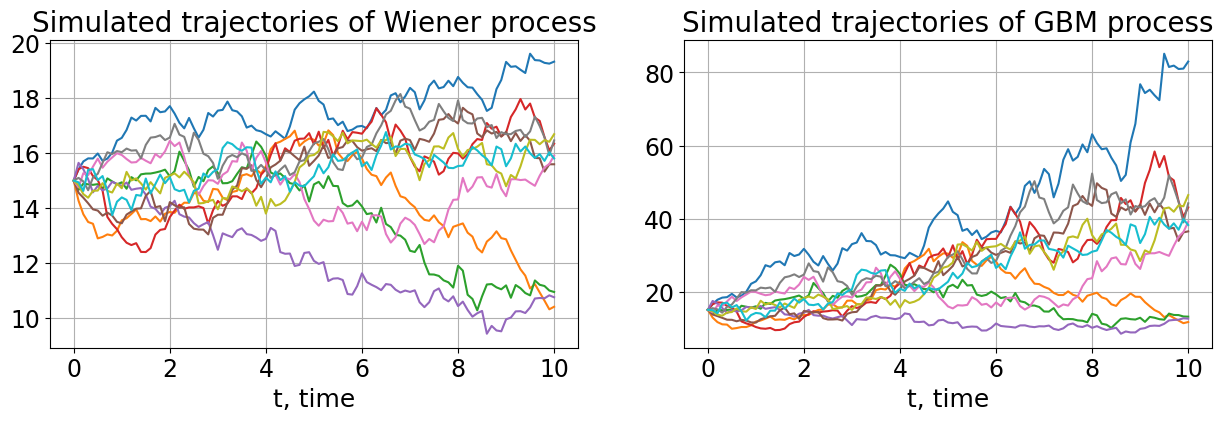

In [4]:
#plots

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,4))

ax1.grid()
ax1.set_title('Simulated trajectories of Wiener process',fontsize=20)
ax1.set_xlabel('t, time',fontsize=18)
ax1.tick_params(axis='x', labelsize=17)
ax1.tick_params(axis='y', labelsize=17)
ax1.plot(ts,wienTrajs.T)

ax2.grid()
ax2.set_title('Simulated trajectories of GBM process',fontsize=20)
ax2.set_xlabel('t, time',fontsize=18)
ax2.tick_params(axis='x', labelsize=17)
ax2.tick_params(axis='y', labelsize=17)
ax2.plot(ts,gbmTrajs.T)
plt.show()

### Подгонка параметров GBM под данные

Загрузите датасет gbmData.pkl, который идёт вместе с ноутбуком и попробуйте оценить модель геометрического Броуновского движения для него. Нарисуйте график, на котором указаны точки данных, матожидание полученного процесса и доверительный интервал; пунктиром нарисуйте несколько реализаций процесса геометрического Броуновского движения.

In [5]:
data = np.load('gbmData.pkl', allow_pickle=True)
ts = data['ts']
xs = data['prices']
gbm = GBMModel(0,1)
gbm.fit(xs, ts)

In [6]:
print(f'Mu = {gbm.mu}')
print(f'Sigma = {gbm.sigma}')

Mu = 0.023831629658874847
Sigma = 0.05135646991818941


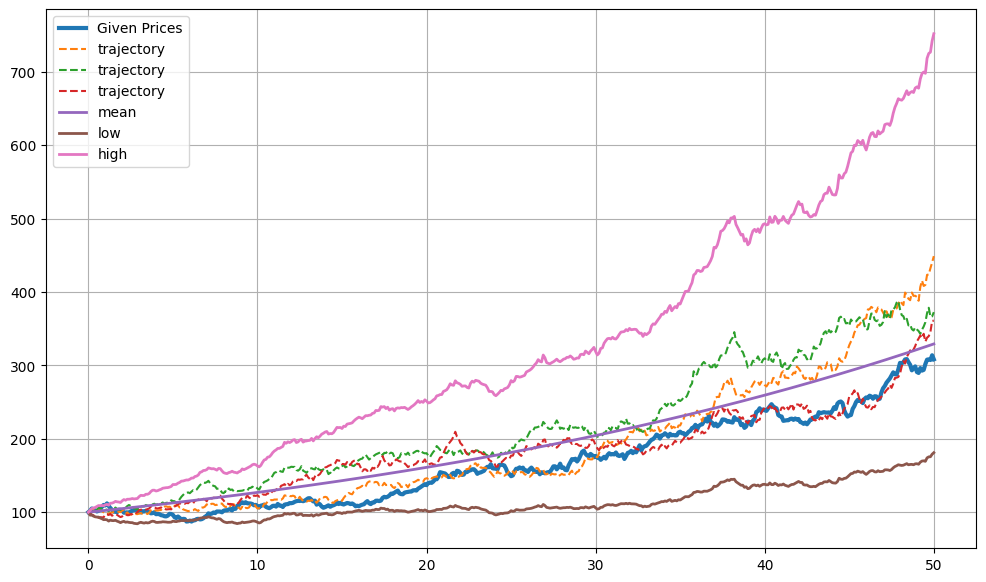

In [7]:
f,ax = plt.subplots(figsize=(12,7))

traj, low, high = gbm.simulate(xs[0], ts, 3, 95)

ax.grid()
#plot given time series
plt.plot(ts, xs, label='Given Prices', linewidth=3)
#plot several simulated trajectories
plt.plot(ts, traj.T, linestyle='--', label='trajectory')
plt.plot(ts, xs[0] * np.exp(gbm.mu * ts), label='mean', linewidth=2)
#plot confidence intervals
plt.plot(ts, low, label='low', linewidth=2)
plt.plot(ts, high, label='high', linewidth=2)
plt.legend()

### Проверка качества предсказаний

Проверим, как хорошо делаются предсказания в полученной модели. Для этого обучите модель на первых $60\%$ ряда, а оставшиеся оставьте для тестов. Попробуйте в разных местах обучающей и тестовой части ряда предсказать следующие 50 наблюдений на основе текущего.

Наилучший в смысле среднеквадратической ошибки прогноз -- это условное матожидание

$$
\mathbb{E}[X_{t+h} \vert X_t] = X_t \mathbb{E}[ e^{(\mu - \sigma^2/2)h + \sigma W_h} ].
$$


Процесс Марковский(как увидим позднее), поэтому предыдущая история не важна. Сравните предсказания GBMModel и тестовые значения, нарисуйте доверительные интервалы (можно их построить для прогноза логарифма, а потом взять экспоненту). Насколько модель подходит для короткосрочного и долгосрочного прогноза?

415.5360126893021
315.56366781495643
98.38256367776778
3120.7784656340755


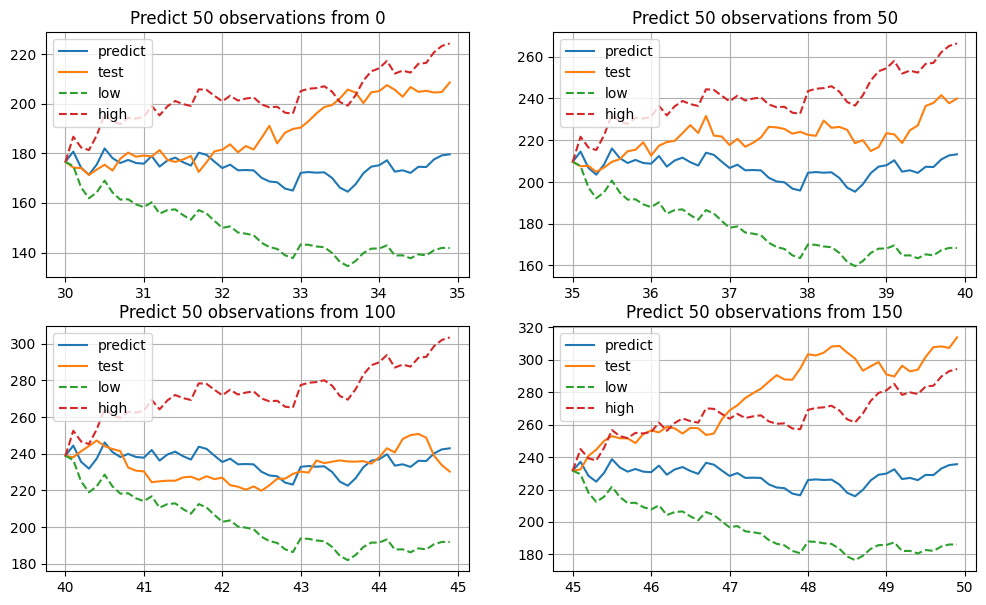

In [8]:
train_ts = ts[:int(0.6 * len(ts))]
train_xs = xs[:int(0.6 * len(xs))]
test_ts = ts[int(0.6 * len(ts)):]
test_xs =xs[int(0.6 * len(xs)):]
gbm = GBMModel(0, 1)
gbm.fit(train_xs, train_ts)




f,ax = plt.subplots(2,2,figsize=(12,7))

start = 0

predict, conflow, confhigh = gbm.predict(test_xs[start], ts[:50], 95)
print(np.mean((predict - test_xs[start:start+50]) ** 2))
ax[0][0].grid()
ax[0][0].plot(test_ts[start:start+50], predict.T, label='predict')
ax[0][0].plot(test_ts[start:start+50], test_xs[start:start+50], label='test')
ax[0][0].plot(test_ts[start:start+50], conflow, label='low', linestyle='--')
ax[0][0].plot(test_ts[start:start+50], confhigh, label='high', linestyle='--')
ax[0][0].legend()
ax[0][0].title.set_text(f'Predict 50 observations from {start}')

start = 50

predict, conflow, confhigh = gbm.predict(test_xs[start], ts[:50], 95)
print(np.mean((predict - test_xs[start:start+50]) ** 2))
ax[0][1].grid()
ax[0][1].plot(test_ts[start:start+50], predict.T, label='predict')
ax[0][1].plot(test_ts[start:start+50], test_xs[start:start+50], label='test')
ax[0][1].plot(test_ts[start:start+50], conflow, label='low', linestyle='--')
ax[0][1].plot(test_ts[start:start+50], confhigh, label='high', linestyle='--')
ax[0][1].legend()
ax[0][1].title.set_text(f'Predict 50 observations from {start}')


start = 100

predict, conflow, confhigh = gbm.predict(test_xs[start], ts[:50], 95)
print(np.mean((predict - test_xs[start:start+50]) ** 2))
ax[1][0].grid()
ax[1][0].plot(test_ts[start:start+50], predict.T, label='predict')
ax[1][0].plot(test_ts[start:start+50], test_xs[start:start+50], label='test')
ax[1][0].plot(test_ts[start:start+50], conflow, label='low', linestyle='--')
ax[1][0].plot(test_ts[start:start+50], confhigh, label='high', linestyle='--')
ax[1][0].legend()
ax[1][0].title.set_text(f'Predict 50 observations from {start}')


start = 150

predict, conflow, confhigh = gbm.predict(test_xs[start], ts[:50], 95)
print(np.mean((predict - test_xs[start:start+50]) ** 2))
ax[1][1].grid()
ax[1][1].plot(test_ts[start:start+50], predict.T, label='predict')
ax[1][1].plot(test_ts[start:start+50], test_xs[start:start+50], label='test')
ax[1][1].plot(test_ts[start:start+50], conflow, label='low', linestyle='--')
ax[1][1].plot(test_ts[start:start+50], confhigh, label='high', linestyle='--')
ax[1][1].legend()
ax[1][1].title.set_text(f'Predict 50 observations from {start}')

plt.show()

Если честно, то я хз. На лекциях было, что gbm нужен для предсказаний в долгосрок, но по графикам получается, что если предсказывать ближе к концу, то предсказание получается достаточно плохим, хотя вначале всё было неплохо. Возможно чем дальше в плане времени, тем больше дисперсия у винеровского процесса и тем более странные предсказания можно получать.

#### Комментарий

Если говорить о математических и вычислительных аспектах, то можно попробовать задать модель и попробовать её с нуля обучить на своей траектории. Увидим, что в нашей модели есть как минимум одна проблема, которая неочевидна с первого взгляда, но почти сразу возникает на практике. Константная волатильность оценивается очень качественно, но параметр сноса очень неустойчивый. Поэтому если на вход приходит не очень удачная (нередкость)  последовательность наблюдений, то снос оценивать сложнее. 

## Часть 2: Задача оценки американского опциона (30 баллов)

### Постановка задачи

Американский опцион даёт право на продажу(put) или покупку(call) актива (или корзины из нескольких активов) по цене страйка $K$ в любой момент времени от $0$ (сейчас) до времени истечения $T$. В классической модели Блека-Шоулза есть безрисковый банковский счёт ставке $r\%$ годовых, а для моделирования цен акций с дивидендами $\delta\%$ годовых используется геометрическое Броуновское движение с параметрами сноса $\mu=r-\delta$ и волатильности $\sigma$. Для простоты в этой задаче мы положим что волатильности $\sigma_i$, дивиденды $\delta_i$ и начальные цены $x_0^i$ у акций отличаются, но цены моделируются как

$$
X^i_t = x_0^i e^{(r-\delta_i - \sigma_i^2/2)t + \sigma_i W^i_t},
$$

где Винеровские процессы $(W^i_t)_{t \in \mathbb{R}_+}$ некоррелированы, то есть, $(W_t)_{t \in \mathbb{R}_+}$ - это $d$-мерный Винеровский процесс.

Из лекций мы знаем, как определяется честная цена европейского опциона, в случае американского идея та же: честная цена равна выгоде, которую можно получить от наилучшего использования опциона. Так как американский опцион можно исполнить в любой момент, то честная цена вычисляется из решения задачи оптимальной остановки:

$$
\max_{\tau \in \Tau} \mathbb{E}\left[ e^{-r\tau}f(X_\tau)\right],
$$

где $f$ -- это функция выплаты опциона, к примеру, $f(x)=(\sum_{i=1}^d x^i - K)_+$, $\tau$ -- это момент остановки, а $\Tau$ -- множество всех возможных времён остановки. Время остановки в данном случае себе проще представлять как решающее правило, которое говорит, когда опцион нужно исполнить, а когда -- подождать ещё. 

Ваша задача состоит в том, чтобы реализовать приближённый метод для оценки американского опциона.


### Описание метода


Для приближённой оценки опциона численными методами, задачу дискретизируют, рассматривая так называемый бермудский опцион, который можно исполнять в моменты $t_k=k\Delta$, где $\Delta=T/p, k=0,..,p$. Для решения этой задачи уже можно пользоваться принципом Беллмана (динамическим программированием). Определим функцию ценности $V_p(x)=f(x)$; действительно, если мы находимся в момент истечения, то опцион сгорает, если мы его не исполнили и приносит прибыль иначе. Более ранние функции ценности строятся рекурсивно: функция ценности 

$$
V_{t_k}(x) = f(x) \vee \left\lbrace e^{-r(t_{k+1}-t_k)} \mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right] \right\rbrace,
$$

где значок $\vee$ обозначает максимум из значения слева и справа. Функция $V_0(x)$ будет, таким образом, честной ценой бермудского опциона при условии текущих цен $X_0=x$.

#### Смещённая вверх оценка (High-Biased Estimator)

Один из подходов может состоять в следующем (Longstaff,Shwarz 2001): на каждом шаге мы решаем задачу регрессии, пытаясь предсказывать

$$
\mathbb{E}\left[ V_{t_{k+1}}(X_{t_{k+1}}) ~\vert~ X_{t_k}=x\right]
$$
по $X_{t_k}$. Чтобы это реализовать мы из момента $t_0$ семплируем независимо $N$ траекторий из модели $(X_t)$, обозначим траекторию $i$ индексом наверху $X_t^i$. В конце мы задаём вектор

$$
    v_p = (V_p(X_p^i)) = (f(X_p^i)), ~~~ i=1,..,N.
$$

Далее на следующих шагах $k-1<p$ мы обучаем некоторую предсказательную модель $\hat{V}_{k-1}: \mathbb{R}^d \to \mathbb{R}$, которая может предсказать по $X_{t_{k-1}}$ значение $V(X_{t_{k}})$ и задаём вектор

$$
    v_{k-1} = (\hat{V}_{k-1}(X_{t_{k-1}}^i)), ~~~ i=1,..,N.
$$

В самом конце в силу того, что все траектории исходят из одной точки (хотя это легко обобщить)

$$
    \hat{V}_{t_0} = \frac{1}{N} \sum_{i=1}^N \hat{V}_{1}(X_{t_1}^i).
$$

#### Нижняя оценка (Lower Bound)

Оказывается, мы можем дёшево получить нижнюю оценку, просто просимулировав ещё $N_{test}$ новых траекторий и посчитав результат обученных моделей (без дополнительного обучения). Чтобы это сделать, надо с имеющимися моделями попробовать исполнить опцион. Можно себе это представлять как разбиение на train и test в классическом машинном обучении.

Конкретнее, семплируется $N_{test}$ траекторий, а дальше каждая проходится и ищется первый момент, где текущая выгода $f(X^{i}_{t})$ выше обещанной $\hat{V}_t(X^{i}_{t})$. Пусть на траектории $i$ алгоритм остановился в момент $\tau_i$. Полученные выгоды с учётом дисконтирования $e^{-r\tau_i}f(X^{i}_{\tau_i})$ нужно усреднить. Это и будет нижней оценкой цены (может, можно лучше, но текущее правило смогло выиграть столько).

Оказывается, что в отличие от классических приложений ML, в этой задаче можно даже построить верхнюю оценку. Чуть позже в курсе мы обсудим, как её можно получить, это уже является более сложным вопросом.

### Имплементация метода

Для реализации нам понадобится модуль симуляции многомерного геометрического Броуновского движения, модуль, реализующий функцию ценности, и модуль, который служит непосредственно для оценки заданного опциона.

Можете использовать для начала шаблоны кода ниже.

#### Симуляция GBM

Уже был реализован в предыдущей части.

In [9]:
def simulateWienerProcess(x0,ts,Ntraj):
    '''
    Simulates trajectories of Wiener process
    Input
    float x0 -- initial value
    float[] ts -- times
    int Ntraj -- number of trajectories to simulate
    Returns
    float[] of shape (Ntraj,len(ts))
    '''
    np.random.seed(0)
    d = len(x0)
    xs = np.zeros((Ntraj, d, len(ts)))
    xs[..., 0] = x0
    for t in range(1, len(ts)):
        xs[..., t] = xs[..., t - 1] + np.random.normal(0, np.sqrt(ts[t] - ts[t-1]), (Ntraj, d))
    return xs

class GBMModel:
    '''
        Implements Geometric Brownian Motion, allowing for parameter estimation and simulations
    '''

    def __init__(self, mu=0,sigma=1):
        '''
        Input
        float mu -- drift parameter (if pre-defined)
        float sigma -- volatility (if pre-defined)
        '''
        self.mu=mu
        self.sigma=sigma


    def fit(self, xs, ts):
        '''
        Fits the parameters to the given time series
        Input
        float[] xs -- observations
        float[] ts -- times (same shape as xs)
        '''
        #YOUR CODE
        y = np.log(xs)
        y = y[:,1:] - y[:, :-1]
        self.sigma = np.std(y, axis=0) / np.sqrt(ts[1] - ts[0])
        self.mu = np.mean(y, axis=0) / (ts[1] - ts[0]) + self.sigma ** 2 / 2
        

    def simulate(self, x0, ts, Ntraj, confLevel=0):
        '''
        Simulates trajectories of GBM with set mu and sigma
        Input
        float x0 -- initial price
        float[] ts -- times
        int Ntraj -- number of trajectories to simulate
        float confLevel -- confidence level, set to non-zero if confInterval is needed
        Returns
        float[] of shape (Ntraj,len(ts)) , trajectories
        if confLevel!=0, 
        then returns  float[] (Ntraj,len(ts)), float[] (len(ts),), float[] (len(ts),) 
        which are trajectories, confidenceLow, confidenceHigh
        '''
        #YOUR CODE
        #Use simulateWienerProcess to simulateW trajectories of Wiener process
        #Based on that, compute GBM
        #For confidence intervals use the exponentiated gaussian intervals of (mu-sigma^2/2)t + sigma W_t
        d = len(x0)
        xs = simulateWienerProcess(np.zeros((d,)), ts, Ntraj)
        ss = x0[None, :, None] * np.exp((self.mu - self.sigma ** 2 / 2) * ts[None, None, :] + self.sigma * xs)
        if confLevel != 0:
            z = scipy.stats.norm.ppf(1 - (1 - confLevel / 100) / 2)
            # confLow = ss.mean(axis=0) - z * ss.std(axis=0) / np.sqrt(ss.shape[1])
            # confHigh = ss.mean(axis=0) + z * ss.std(axis=0) / np.sqrt(ss.shape[1])
            confLow = ss.mean(axis=0) * np.exp(-0.5 * self.sigma ** 2 * ts - z * self.sigma * np.sqrt(ts))
            confHigh = ss.mean(axis=0) * np.exp(-0.5 * self.sigma ** 2 * ts + z * self.sigma * np.sqrt(ts))
            return ss, confLow, confHigh
        return ss

    def predict(self,x0,ts, confLevel=0):
        '''
        Makes a prediction based on the fact that at ts[0] the process value equals x0
        Input
        float x0 -- initial price
        float[] ts -- times for predictions
        Returns
        float[] preds, float[] confIntLows, float[] confIntHigh
        predictions (len(ts)), confIntLows (len(ts)), confIntHighs (len(ts))
        '''
        return self.simulate(x0, ts, 1, confLevel)

#### (Приближённая) Функция ценности

Функция ценности имеет метод для оценки условного матожидания и метод для обучения и предсказания. Практически полностью повторяет sklearn, но с дополнительной обёрткой иногда удобнее.

In [10]:
class ValueFunction:

    def __init__(self):
        '''
        Input
        Obj model -- object implementing methods fit() and predict(), may contain sklearn or torch models
        '''
        self.model =  sklearn.linear_model.LinearRegression()

    def fit(self,X,y):
        '''
        Fits continuation value
        Input
        float[][] X -- training set of shape (batch, d)
        float[] y -- training targets of shape (batch,)
        '''
        self.model.fit(X,y)
    
    def predict(self,X):
        '''
        Predicts continuation value given current price vectors X
        Input
        float[][] X -- set of price vectors of shape (batch, d)
        Returns
        float[] contValues (batch,)
        '''
        return self.model.predict(X)

    def getParameters(self):
        return self.model.coef_

#### Метод оценки опциона

Теперь реализуем сам метод оценки. Мы должны уметь вычислить как смещённую оценку, так и нижнюю. Используйте шаблон ниже.

In [11]:
class OptionPricer:

    '''Base class for option pricing'''

    def __init__(self,priceModel,payment,executionTimes,discountFunction):
        '''
        Input
        Obj priceModel -- GBMModel serving as simulator
        functionHandler payment -- function taking X (batch,d) and returning payments f(X) of shape (batch,)
        float horizon -- expiration time(in years)
        float[] executionTimes -- times when it is possible to execute the option
        functionHandler discountFunction -- function returning discounting rate based on the time (classic is e^{-r*h} like above)
        '''
        self.priceModel = priceModel
        self.payment = payment
        self.executionTimes = executionTimes
        self.continuationModels = [ValueFunction()]*(len(executionTimes)-2)
        self.dicountFunction = discountFunction



    def computeHighBiasEstimator(self,x0, Ntrajs):
        '''
        Trains value functions and computes highBias estimator of the price
        Input
        int Ntrajs -- number of trajectories to sample
        Returns
        price, priceStd -- price estimation and estimated standard deviation
        '''
        prices = self.priceModel.simulate(x0, self.executionTimes, Ntrajs)
        option_values = np.zeros((Ntrajs, len(self.executionTimes)))
        option_values[:, -1] = self.payment(prices[..., -1])
        for t in range(len(self.executionTimes) - 2, 0, -1):
            X_train = prices[..., t-1]
            y_train = np.maximum(self.payment(prices[..., t]), option_values[:, t + 1] * self.dicountFunction(self.executionTimes[t + 1] - self.executionTimes[t]))
            self.continuationModels[t - 1].fit(X_train, y_train)
            option_values[:, t] = self.continuationModels[t - 1].predict(X_train)

        return np.mean(option_values[:, 1]), np.std(option_values[:, 2])
        

    def computeLowEstimator(self,x0, Ntrajs):
        '''
        Computes low estimate of the price based on trained value functions and new sampled test set of trajectories
        Input
        int Ntrajs -- number of trajectories to use for estimation
        Returns
        priceLow,priceLowStd -- low estimation of the price and its estimated standard deviation
        '''
        prices = self.priceModel.simulate(x0, self.executionTimes, Ntrajs)
        profit = self.payment(prices)
        option = np.zeros(profit.shape)
        for i in range(len(self.continuationModels)):
            option[:, i + 1] = self.continuationModels[i].predict(prices[..., i])
        option[:, -1] = profit[:, -1]
        diff = profit - option
        times = np.argmax(diff > 0, axis=1)
        val = diff[np.arange(diff.shape[0]), times]
        return (val * self.dicountFunction(self.executionTimes[times])).mean(), (val * self.dicountFunction(self.executionTimes[times])).std()

### Проведение экспериментов

Прим.: $+$ это то же, что [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))

В качестве иллюстрации метода, рассмотрим три пример с функцией выплаты $f(x) = (\max_i x_i - K)_+$ (американский max-call опцион со страйком $K=100$) для двух акций $X^1,X^2$ с начальными ценами

1. $X_0= [100,100]$;
2. $X_0= [110,110]$;
3. $X_0= [90,90]$.

Параметры модели: банковская процентная ставка $r=0.05$ годовых, для каждой акции дивиденды $\delta=0.1$ годовых, волатильность $\sigma=0.2$, истечение срока опциона $T=1$ год. Используется геометрическое Броуновское движение с параметрами $\mu=r-\delta$ и $\sigma$, шаг дискретизации $0.1$ (число разбиений равно $10$). Max-call опцион позволяет купить товар из корзины, который имеет максимальную цену в момент исполнения, по цене страйка $K$.

Для каждого из трёх сценариев проведите следующий эксперимент: посчитайте цену опциона(high-biased) для числа траекторий для обучения $N=500,1000,2000,4000,8000,16000$ и вычислите для каждого из них нижнюю оценку на $N_{test}=40000$ траекториях. Постройте график с двумя кривыми цен и гауссовскими доверительными интервалами, отображающий зависимость вычисленной цены от $N$. Сделайте вывод: какой из трёх опционов дороже? Как вы считаете, почему?

Сравните вычисленные цены с ценой европейского опциона для этих трёх примеров, в чём причина того, что его цена ниже?

In [12]:
r = 0.05
delta = 0.1
sigma = 0.2
ts = np.arange(0., 1.1, 0.1)
K = 100

In [13]:
def payment(prices):
    return np.maximum(np.max(prices, axis=1) - K, 0)

def discountFunction(time):
    return np.exp(-r * time)

In [14]:
priceModel = GBMModel(r - delta, sigma)
option = OptionPricer(priceModel, payment, ts, discountFunction)

x0 = np.array([[100, 100], [110, 110], [90, 90]])

trajs = [500, 1000, 2000, 4000, 8000, 16000]
test_traj = 40000

res = {'prices':{'high':[], 'low':[]}, 'conf':{'high':{'conf_high':[], 'conf_low':[]}, 'low':{'conf_high':[], 'conf_low':[]}}}
conflevel = 0.95
z = scipy.stats.norm.ppf(1 - (1 - conflevel) / 2)

for i in range(len(x0)):
    print(f'{i+1} start price')
    high_pr = []
    high_pr_conf_high = []
    high_pr_conf_low = []
    low_pr = []
    low_pr_conf_high = []
    low_pr_conf_low = []
    for traj in trajs:
        tmp = option.computeHighBiasEstimator(x0[i], traj)
        high_pr.append(tmp[0])
        high_pr_conf_high.append(high_pr[-1] + z * tmp[1] / np.sqrt(traj))
        high_pr_conf_low.append(high_pr[-1] - z * tmp[1] / np.sqrt(traj))
        print(f'N = {traj}')
        print(f'high-biased option price is {tmp[0]} ± {tmp[1]}')
        tmp = option.computeLowEstimator(x0[i], test_traj)
        low_pr.append(tmp[0])
        low_pr_conf_high.append(low_pr[-1] + z * tmp[1] / np.sqrt(test_traj))
        low_pr_conf_low.append(low_pr[-1] - z * tmp[1] / np.sqrt(test_traj))
        print(f'low estimate is {tmp[0]} ± {tmp[1]}')
        print()
    res['prices']['high'].append(high_pr)
    res['prices']['low'].append(low_pr)
    res['conf']['high']['conf_high'].append(high_pr_conf_high)
    res['conf']['high']['conf_low'].append(high_pr_conf_low)
    res['conf']['low']['conf_high'].append(low_pr_conf_high)
    res['conf']['low']['conf_low'].append(low_pr_conf_low)
    

# print(option.computeHighBiasEstimator(x0[0], traj))
# print(option.computeLowEstimator(x0[2], test_traj))

1 start price
N = 500
high-biased option price is 14.506153952302979 ± 3.726237751044933
low estimate is 1.8689577765546528 ± 3.1541207882931745

N = 1000
high-biased option price is 15.420225507706334 ± 3.843846269553599
low estimate is 1.764324083083811 ± 3.105403441822723

N = 2000
high-biased option price is 15.380870186234548 ± 3.990460375100487
low estimate is 1.7670734496389013 ± 3.106844540068596

N = 4000
high-biased option price is 15.361237171648954 ± 3.757128074374858
low estimate is 1.768035819635977 ± 3.103997255614622

N = 8000
high-biased option price is 15.599054015385212 ± 3.986554892514472
low estimate is 1.7501660609604401 ± 3.104472056862348

N = 16000
high-biased option price is 15.649241700595951 ± 3.9794832465205667
low estimate is 1.7422322678288649 ± 3.0994865150766198

2 start price
N = 500
high-biased option price is 23.390703845168012 ± 4.987419536716464
low estimate is 10.0 ± 0.0

N = 1000
high-biased option price is 24.347919480275895 ± 5.200656731288067


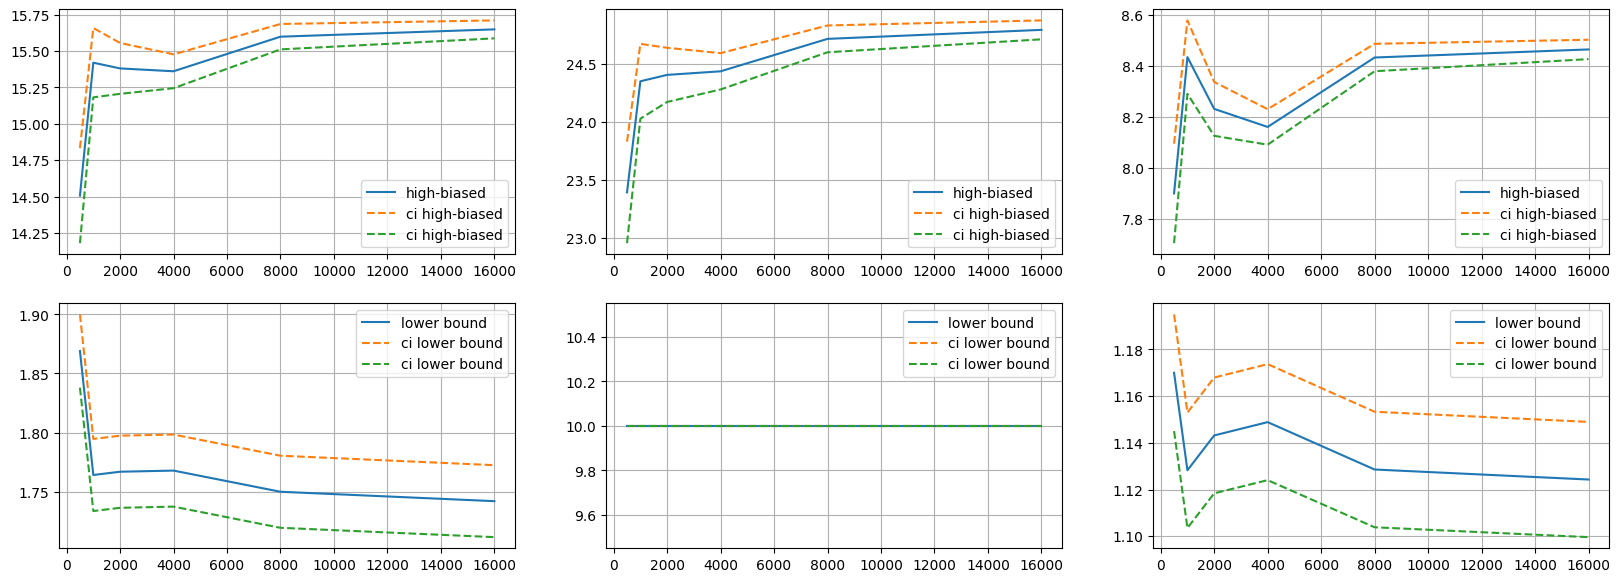

In [15]:
f,ax = plt.subplots(2,3,figsize=(20,7))

for i in range(3):
    ax[0][i].grid()
    ax[1][i].grid()
    ax[0][i].plot(trajs, res['prices']['high'][i], label='high-biased')
    ax[0][i].plot(trajs, res['conf']['high']['conf_high'][i], label='ci high-biased', linestyle='--')
    ax[0][i].plot(trajs, res['conf']['high']['conf_low'][i], label='ci high-biased', linestyle='--')
    ax[1][i].plot(trajs, res['prices']['low'][i], label='lower bound')
    ax[1][i].plot(trajs, res['conf']['low']['conf_high'][i], label='ci lower bound', linestyle='--')
    ax[1][i].plot(trajs, res['conf']['low']['conf_low'][i], label='ci lower bound', linestyle='--')

    ax[0][i].legend()
    ax[1][i].legend()


In [16]:
def priceEuropeanCall(x0, NSamples=10, T=1.0,f=payment, priceModel=priceModel):
    '''
    Sets a price on european put-option
    Input
    float[] x0 -- current prices, (d,)
    float[] mu -- mu parameter, (d,)
    float[] sigma -- sigma parameter, (d,)
    functionHandler f -- payment function, R^d --> R
    float T -- expiration time
    int NSamples -- number of Monte Carlo samples to use
    '''
    xs = priceModel.simulate(x0, np.array([0,T]), NSamples)

    payments = f(xs[:,:,-1])
    priceMean = np.mean(payments)
    priceStd = np.std(payments)

    return priceMean, priceStd

res_eo = {'price':[], 'conf':{'high':[], 'low':[]}}

for i in range(len(x0)):
    print(f'{i+1} start price')
    pr = []
    pr_conf_high = []
    pr_conf_low = []
    for traj in trajs:
        tmp = priceEuropeanCall(x0[i], traj)
        pr.append(tmp[0])
        pr_conf_high.append(pr[-1] + z * tmp[1] / np.sqrt(traj))
        pr_conf_low.append(pr[-1] - z * tmp[1] / np.sqrt(traj))
        print(f'N = {traj}')
        print(f'high-biased option price is {tmp[0]} ± {tmp[1]}')
        print()
    res_eo['price'].append(pr)
    res_eo['conf']['high'].append(pr_conf_high)
    res_eo['conf']['low'].append(pr_conf_low)


1 start price
N = 500
high-biased option price is 9.368367752636608 ± 13.065978781486923

N = 1000
high-biased option price is 9.73548930039744 ± 13.159944912129108

N = 2000
high-biased option price is 9.576739289153059 ± 13.081580591690077

N = 4000
high-biased option price is 9.77183646714491 ± 13.349892633602002

N = 8000
high-biased option price is 9.820040520134341 ± 13.399888547381318

N = 16000
high-biased option price is 9.882798502546104 ± 13.445116776615054

2 start price
N = 500
high-biased option price is 16.966449110511995 ± 17.16055848202446

N = 1000
high-biased option price is 17.491400733958027 ± 17.230205938883998

N = 2000
high-biased option price is 17.38528282480162 ± 17.07430800595374

N = 4000
high-biased option price is 17.627659474770983 ± 17.336907398600225

N = 8000
high-biased option price is 17.693307962245484 ± 17.386090461871476

N = 16000
high-biased option price is 17.8205870090485 ± 17.399746590451613

3 start price
N = 500
high-biased option price is

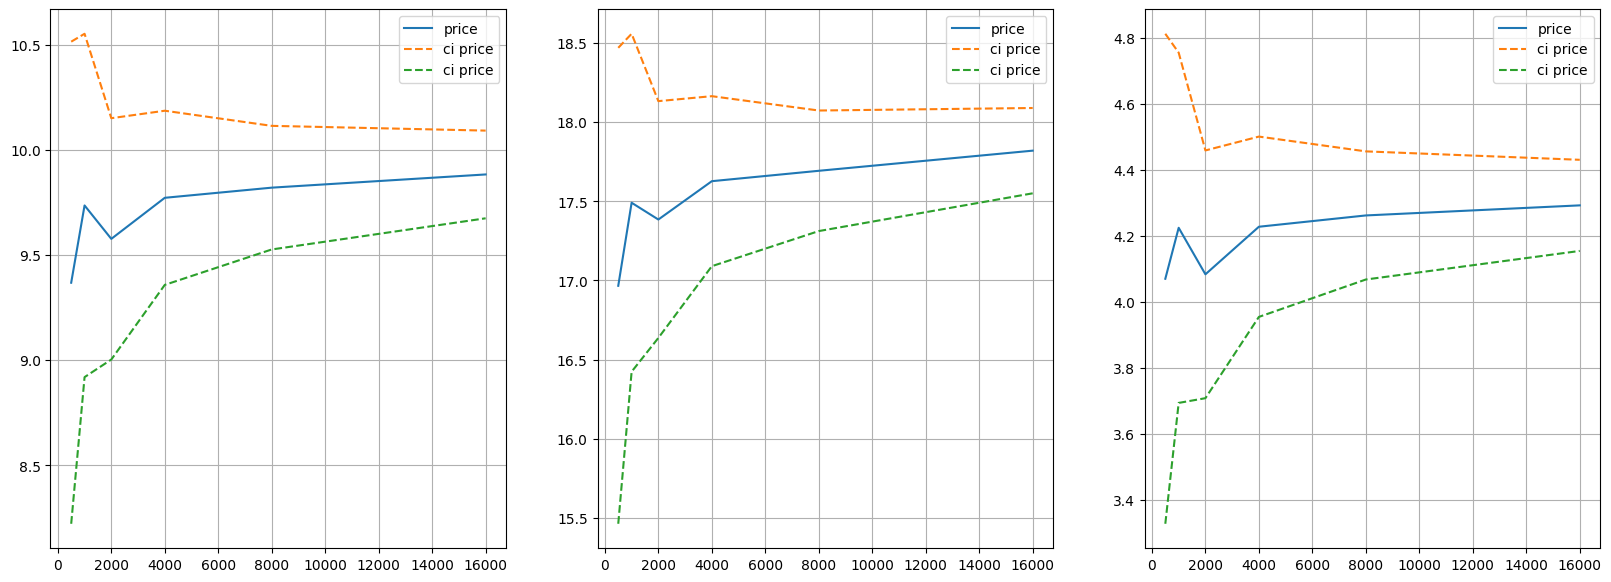

In [17]:
f,ax = plt.subplots(1,3,figsize=(20,7))

for i in range(3):
    ax[i].grid()
    ax[i].plot(trajs, res_eo['price'][i], label='price')
    ax[i].plot(trajs, res_eo['conf']['high'][i], label='ci price', linestyle='--')
    ax[i].plot(trajs, res_eo['conf']['low'][i], label='ci price', linestyle='--')

    ax[i].legend()


Самым дорогим оказался опцион на акции, которые стоят дороже(то есть 110). Это достаточно логично, ведь если у нас есть акция за 100 рублей и опцион со страйком 100 и ценой 5, то при росте акции до 120, цена опциона должна вырасти, иначе мы можем купить ещё по цене, которая ниже рыночно. Но это с call опционами(то есть в нашем случае). С put обратная ситация.

Также американский опцион оказался дороже европейского. Опять же, довольно логично: за возможно продать(или нет) тогда, когда нам выгодно, мы должны платить больше.